# Initial data

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install pyarrow

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, f1_score
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


import matplotlib.pyplot as plt


In [ ]:
df_a_events = pd.read_parquet("A_events.parquet")
df_a_components = pd.read_parquet("A_components.parquet")
df_b_events = pd.read_parquet("B_events.parquet")
df_b_components = pd.read_parquet("B_components.parquet")
df_c_events = pd.read_parquet("C_events.parquet")
df_c_components = pd.read_parquet("C_components.parquet")

In [ ]:
def merge_events_components(events_df, components_df):
    # Drop common columns from events_df (except 'Attack ID')
    common_columns = set(events_df.columns) & set(components_df.columns)
    common_columns.discard("Attack ID")

    events_df_clean = events_df.drop(columns=common_columns)

    # Merge on 'Attack ID'
    merged_df = pd.merge(
        components_df,
        events_df_clean,
        on="Attack ID",
        how="inner"
    )

    return merged_df

In [ ]:
df_a = merge_events_components(df_a_events, df_a_components)
df_b = merge_events_components(df_b_events, df_b_components)
df_c = merge_events_components(df_c_events, df_c_components)

df = pd.concat([df_a, df_b], ignore_index=True)

# Data preprocessing

In [ ]:
def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    # Drop unnecessary columns
    df = df.drop(columns=["Card", "Significant flag", "Whitelist flag", "Attack code", "Detect count"], errors='ignore')

    # Filter out rows where Start time or End time is "0"
    df = df[
        (df["Start time"] != "0") &
        (df["End time"] != "0")
    ]

    # Convert to datetime and extract time features
    df["Start time"] = pd.to_datetime(df["Start time"])
    df["End time"] = pd.to_datetime(df["End time"])

    df["Start_time_hour"] = df["Start time"].dt.hour
    df["Start_time_weekday"] = df["Start time"].dt.weekday
    df["Start_time_dayofyear"] = df["Start time"].dt.dayofyear

    df["End_time_hour"] = df["End time"].dt.hour
    df["End_time_weekday"] = df["End time"].dt.weekday
    df["End_time_dayofyear"] = df["End time"].dt.dayofyear

    # Helper for cyclical encoding
    def sin_cos_encode(series: pd.Series, period: int) -> tuple[pd.Series, pd.Series]:
        radians = 2 * np.pi * series / period
        return np.sin(radians), np.cos(radians)

    # Apply cyclical encoding
    df["Start_time_hour_sin"], df["Start_time_hour_cos"] = sin_cos_encode(df["Start_time_hour"], 24)
    df["Start_time_weekday_sin"], df["Start_time_weekday_cos"] = sin_cos_encode(df["Start_time_weekday"], 7)
    df["Start_time_dayofyear_sin"], df["Start_time_dayofyear_cos"] = sin_cos_encode(df["Start_time_dayofyear"], 365)

    df["End_time_hour_sin"], df["End_time_hour_cos"] = sin_cos_encode(df["End_time_hour"], 24)
    df["End_time_weekday_sin"], df["End_time_weekday_cos"] = sin_cos_encode(df["End_time_weekday"], 7)
    df["End_time_dayofyear_sin"], df["End_time_dayofyear_cos"] = sin_cos_encode(df["End_time_dayofyear"], 365)

    # Extract numeric part from Victim IP
    df["Victim IP Number"] = df["Victim IP"].str.extract(r"IP_(\d+)").astype(int)

    # Preserve original Type column
    df["Type_Original"] = df["Type"]

    # One-hot encode the Type column
    df = pd.get_dummies(df, columns=['Type'])

    # Rename the original Type column back
    df = df.rename(columns={"Type_Original": "Type"})

    # Rename columns for consistency
    df = df.rename(columns={
        "Victim IP Number": "victim_ip",
        "Port number": "port_number",
        "Packet speed": "packet_speed",
        "Data speed": "data_speed",
        "Avg packet len": "packet_len",
        "Source IP count": "source_ip",
        "Start_time_hour_sin": "start_hour",
        "Start_time_weekday_sin": "start_weekday",
        "Start_time_dayofyear_sin": "start_dayofyear",
        "End_time_hour_sin": "end_hour",
        "End_time_weekday_sin": "end_weekday",
        "End_time_dayofyear_sin": "end_dayofyear",
        "Type_DDoS attack": "type_ddos",
        "Type_Normal traffic": "type_normal",
        "Type_Suspicious traffic": "type_sus"
    })

    # Select final set of columns
    selected_columns = [
        "victim_ip", "port_number", "packet_speed", "data_speed", "packet_len", "source_ip",
        "start_hour", "start_weekday", "start_dayofyear",
        "end_hour", "end_weekday", "end_dayofyear",
        "type_ddos", "type_normal", "type_sus"
    ]
    df = df[selected_columns]

    # Refactor: consolidate type columns into single label
    df["type"] = df[["type_ddos", "type_sus", "type_normal"]].idxmax(axis=1)
    df["type"] = df["type"].map({
        "type_ddos": "ddos",
        "type_sus": "sus",
        "type_normal": "normal"
    })

    # Drop the one-hot columns after mapping
    df = df.drop(columns=["type_ddos", "type_sus", "type_normal"])

    return df

In [ ]:
df = preprocess_df(df)
df_eval = preprocess_df(df_c)

# Logistic regression
Baseline algorithm used in previous milestones

Uses binary classification, 1 if sus, otherwise 0

In [ ]:
def visualize_results(y_true, y_pred_prob, threshold: float = 0.5):
    y_pred = (y_pred_prob >= threshold).astype(int)

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    cm = confusion_matrix(y_true, y_pred)

    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    pr_auc = average_precision_score(y_true, y_pred_prob)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
    axes[0].plot([0, 1], [0, 1], "--", color="gray")
    axes[0].set_title("ROC Curve")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend()

    axes[1].plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
    axes[1].set_title("Precision-Recall Curve")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[2], colorbar=False)
    axes[2].set_title(f"Confusion Matrix (F1 = {f1:.2f})")

    plt.tight_layout()
    plt.show()

In [ ]:
def logistic_regression_ab(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X = df[feature_cols].copy()
    y = (df["type"] == "ddos").astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)[:, 1]

    visualize_results(y_test, y_prob)

    return {
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "pr_auc": average_precision_score(y_test, y_prob)
    }

In [ ]:
def logistic_regression_abc(df: pd.DataFrame, df_eval: pd.DataFrame) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X_train = df[feature_cols].copy()
    y_train = (df["type"] == "ddos").astype(int)

    X_eval = df_eval[feature_cols].copy()
    y_eval = (df_eval["type"] == "ddos").astype(int)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_eval_scaled = scaler.transform(X_eval)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_eval_scaled)
    y_prob = clf.predict_proba(X_eval_scaled)[:, 1]

    visualize_results(y_eval, y_prob)

    return {
        "f1": f1_score(y_eval, y_pred),
        "roc_auc": roc_auc_score(y_eval, y_prob),
        "pr_auc": average_precision_score(y_eval, y_prob)
    }

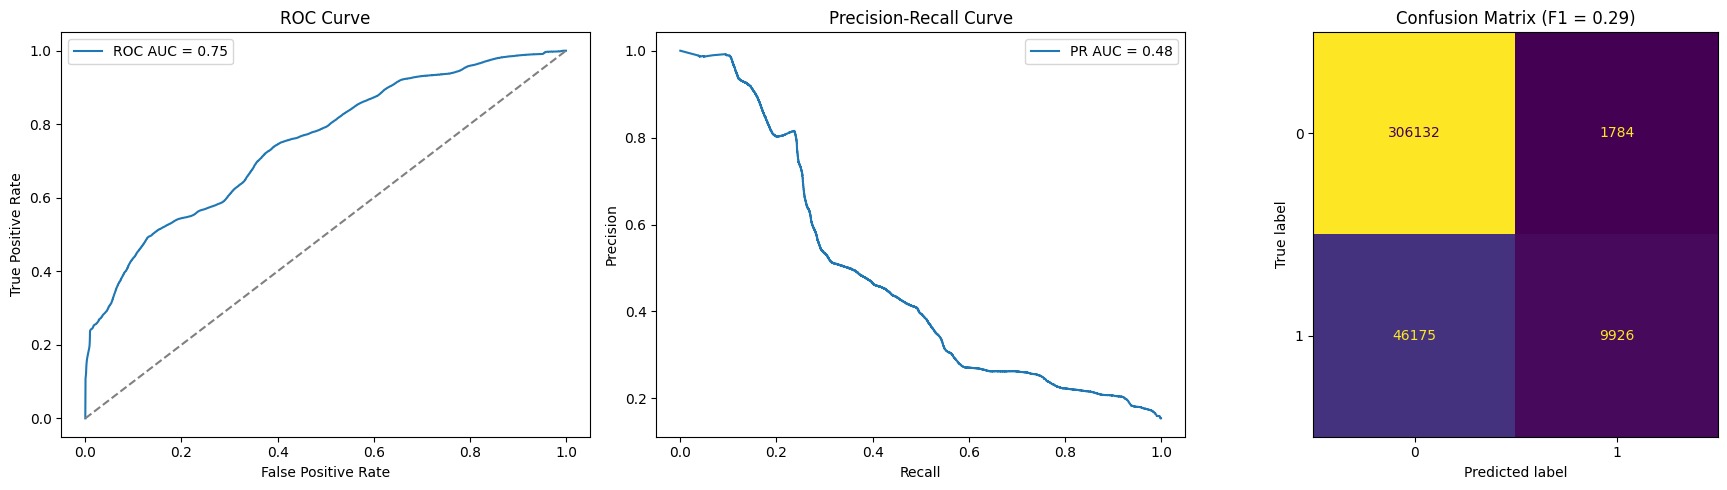

{'f1': 0.2927548627803749,
 'roc_auc': np.float64(0.7490773606818695),
 'pr_auc': np.float64(0.47569113673774766)}

In [ ]:
logistic_regression_ab(df)

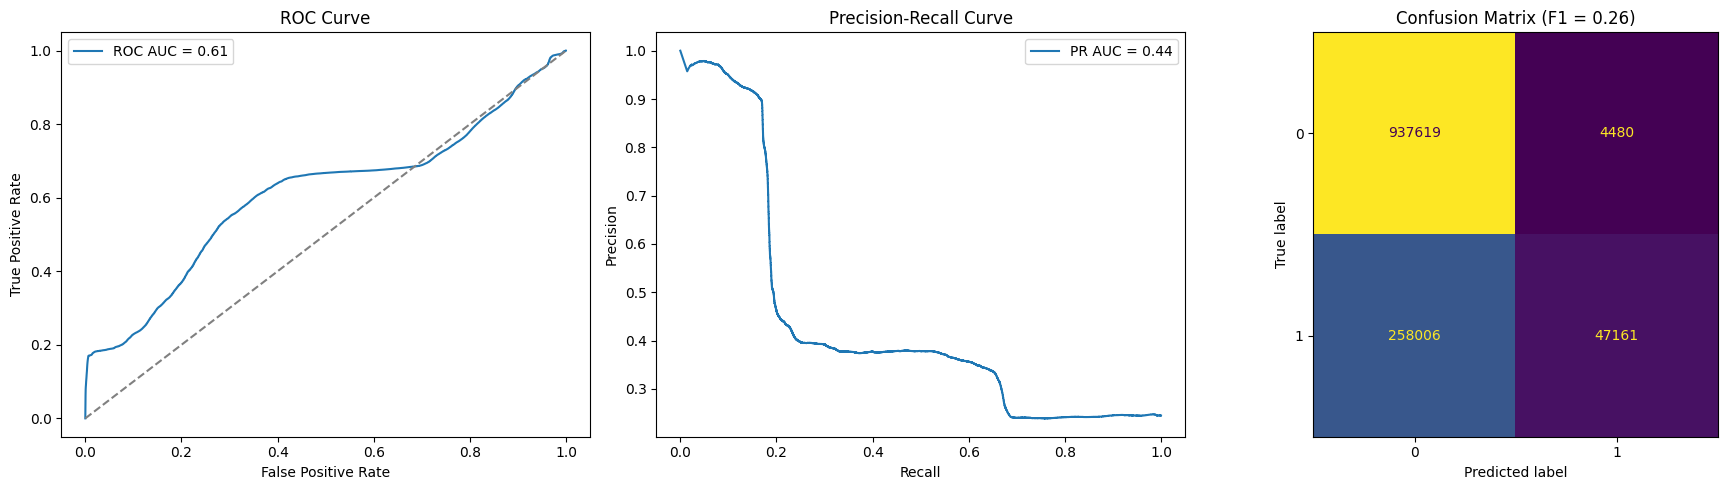

{'f1': 0.2643494540481155,
 'roc_auc': np.float64(0.6080286963406752),
 'pr_auc': np.float64(0.43851353587919767)}

In [ ]:
logistic_regression_abc(df, df_eval)

# Decision trees

In [ ]:
def visualize_decision_tree(clf, feature_names, class_names, max_depth=3):
    plt.figure(figsize=(20, 10))
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        max_depth=max_depth,
        fontsize=10
    )
    plt.title("Decision Tree Visualization (Top Levels)")
    plt.show()

In [ ]:
def decision_tree_ab(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X = df[feature_cols].copy()
    y = df["type"]

    classes = ["ddos", "normal", "sus"]
    y_bin = label_binarize(y, classes=classes)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = DecisionTreeClassifier(random_state=random_state)
    clf.fit(X_train_scaled, y_train)
    # visualize_decision_tree(clf, feature_names=X.columns, class_names=["ddos", "normal", "sus"])

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)  # shape: (n_samples, n_classes)

    # One-vs-rest ROC AUC and PR AUC for each class
    y_test_bin = label_binarize(y_test, classes=classes)

    roc_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_test_bin, y_prob, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    # Optional: visualize ROC for one class (e.g. "sus")
    if "sus" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_test == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

In [ ]:
def decision_tree_abc(df: pd.DataFrame, df_eval: pd.DataFrame) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X_train = df[feature_cols].copy()
    y_train = df["type"]

    X_eval = df_eval[feature_cols].copy()
    y_eval = df_eval["type"]

    classes = ["ddos", "normal", "sus"]
    y_eval_bin = label_binarize(y_eval, classes=classes)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_eval_scaled = scaler.transform(X_eval)

    # Train
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train_scaled, y_train)
    # visualize_decision_tree(clf, feature_names=X_train.columns, class_names=["ddos", "normal", "sus"])

    # Predict
    y_pred = clf.predict(X_eval_scaled)
    y_prob = clf.predict_proba(X_eval_scaled)

    # Evaluate
    f1 = f1_score(y_eval, y_pred, average="macro")
    roc_auc = roc_auc_score(y_eval_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_eval_bin, y_prob, average="macro")

    # Optional visualization for "sus"
    if "sus" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_eval == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

In [ ]:
def decision_tree_abc_improved(df: pd.DataFrame, df_eval: pd.DataFrame) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X_train = df[feature_cols].copy()
    y_train = df["type"]

    X_eval = df_eval[feature_cols].copy()
    y_eval = df_eval["type"]

    classes = ["ddos", "normal", "sus"]
    y_eval_bin = label_binarize(y_eval, classes=classes)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_eval_scaled = scaler.transform(X_eval)

    clf = DecisionTreeClassifier(
        max_depth=12,             # more flexible than 6
        min_samples_split=4,      # fewer required to split
        min_samples_leaf=2,       # small leaf allowed
        ccp_alpha=0.0,            # no pruning for now
        random_state=42
    )
    clf.fit(X_train_scaled, y_train)

    # # Visualize limited-depth tree
    # visualize_decision_tree(
    #     clf,
    #     feature_names=X_train.columns,
    #     class_names=classes,
    #     max_depth=3  # shallow visualization
    # )

    # Predict and evaluate
    y_pred = clf.predict(X_eval_scaled)
    y_prob = clf.predict_proba(X_eval_scaled)
    f1 = f1_score(y_eval, y_pred, average="macro")
    roc_auc = roc_auc_score(y_eval_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_eval_bin, y_prob, average="macro")

    # Optional: visualize "sus" class performance
    if "sus" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_eval == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

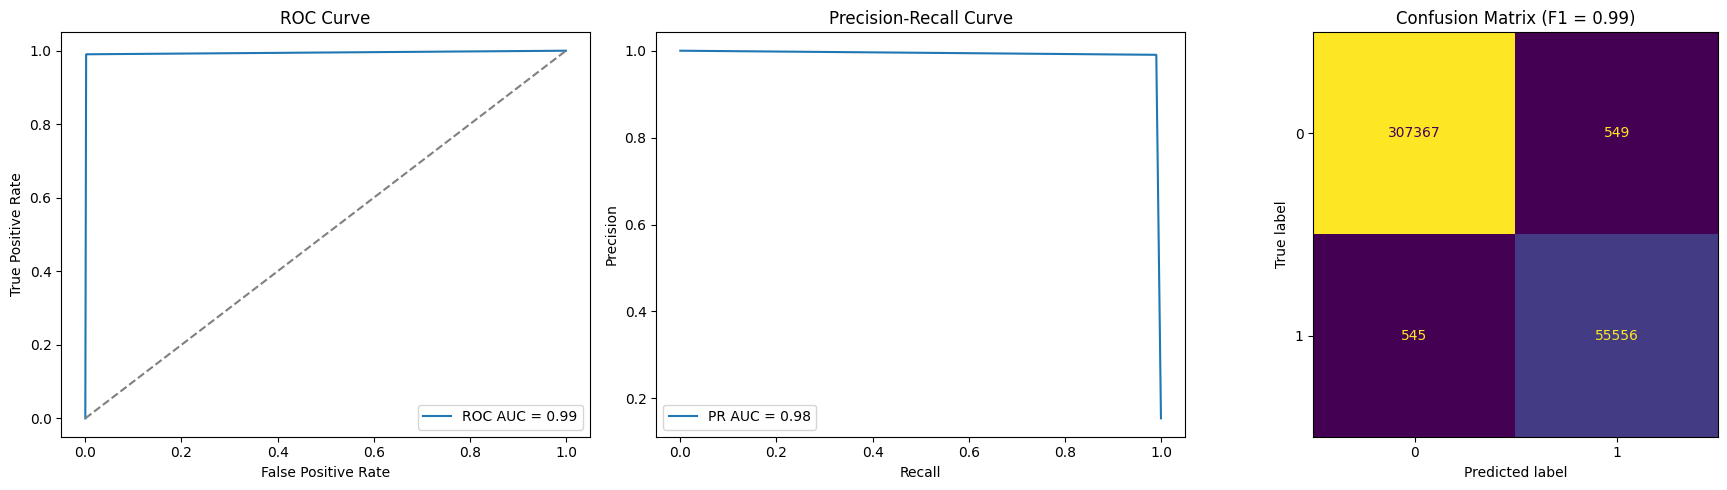

{'f1_macro': 0.9643220555284647,
 'roc_auc_macro': np.float64(0.9789051857819673),
 'pr_auc_macro': np.float64(0.9345512711476376)}

In [ ]:
decision_tree_ab(df)

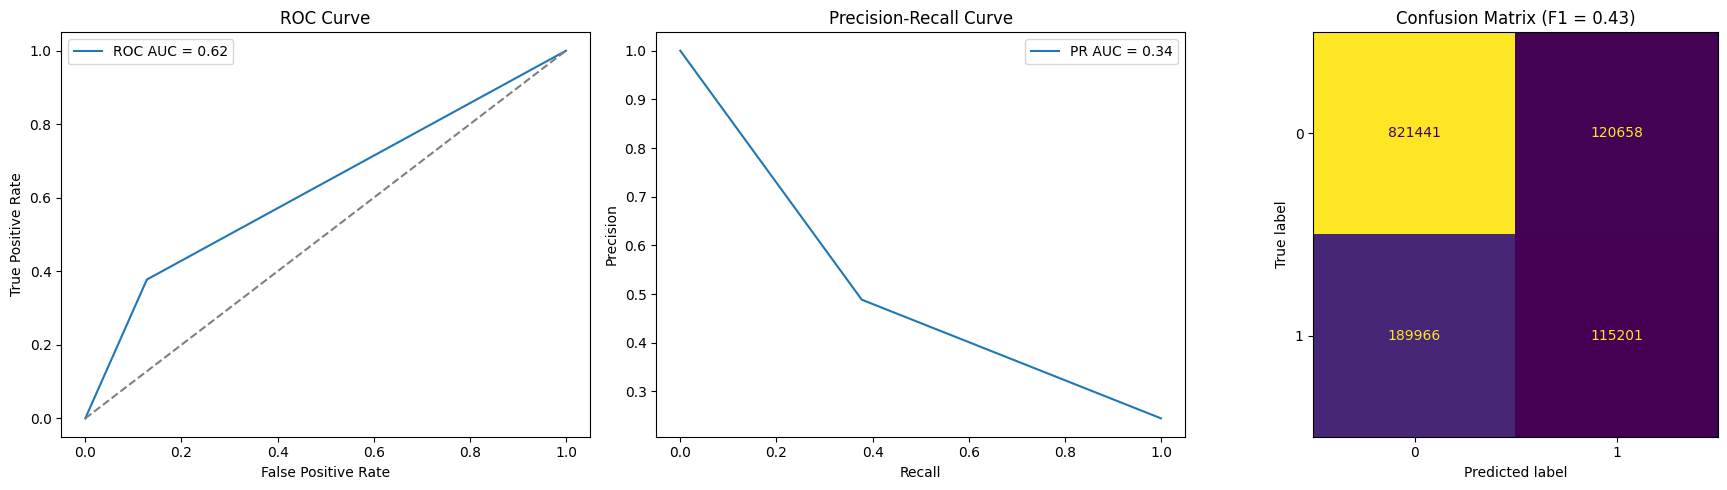

{'f1_macro': 0.5500598859246522,
 'roc_auc_macro': np.float64(0.6409467648832456),
 'pr_auc_macro': np.float64(0.43189421420656715)}

In [ ]:
decision_tree_abc(df, df_eval)

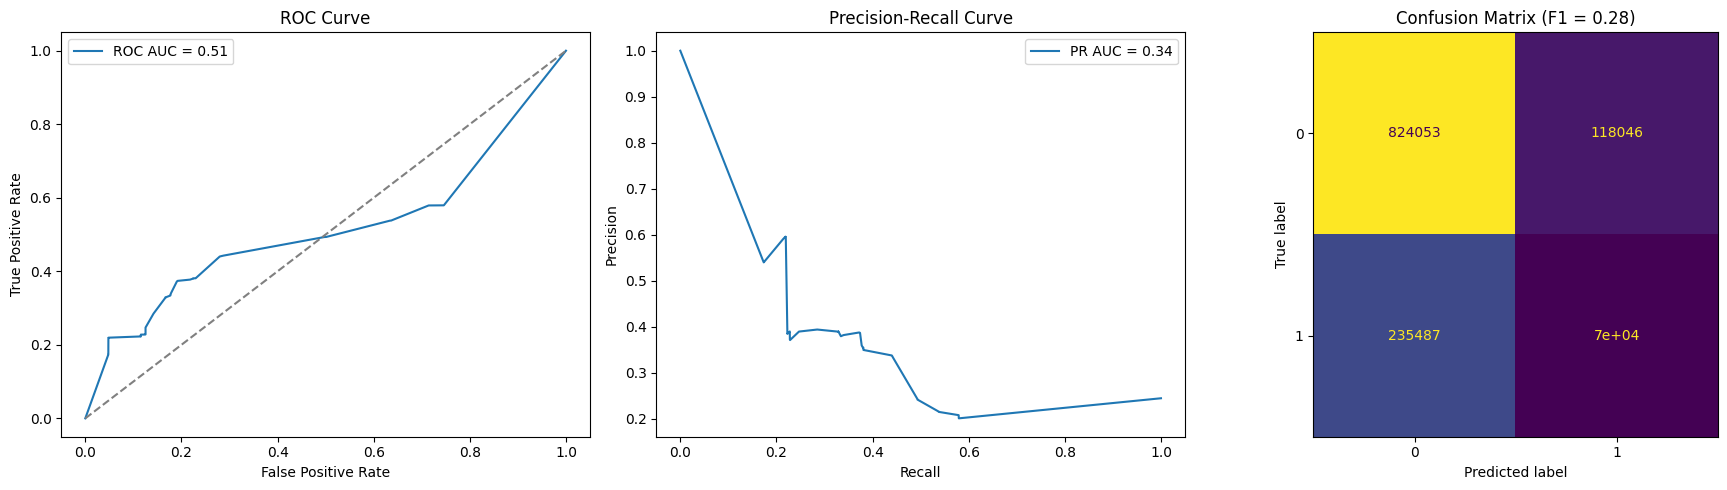

{'f1_macro': 0.4193891735219848,
 'roc_auc_macro': np.float64(0.6117394691975565),
 'pr_auc_macro': np.float64(0.5038024039678687)}

In [ ]:
decision_tree_abc_improved(df, df_eval)

# Random forest

In [ ]:
def random_forest_ab(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X = df[feature_cols].copy()
    y = df["type"]

    classes = ["ddos", "normal", "sus"]
    y_bin = label_binarize(y, classes=classes)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)

    y_test_bin = label_binarize(y_test, classes=classes)

    roc_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_test_bin, y_prob, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    if "ddos" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_test == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

In [ ]:
def random_forest_abc(df: pd.DataFrame, df_eval: pd.DataFrame) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X_train = df[feature_cols].copy()
    y_train = df["type"]

    X_eval = df_eval[feature_cols].copy()
    y_eval = df_eval["type"]

    classes = ["ddos", "normal", "sus"]
    y_eval_bin = label_binarize(y_eval, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_eval_scaled = scaler.transform(X_eval)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_eval_scaled)
    y_prob = clf.predict_proba(X_eval_scaled)

    f1 = f1_score(y_eval, y_pred, average="macro")
    roc_auc = roc_auc_score(y_eval_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_eval_bin, y_prob, average="macro")

    if "ddos" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_eval == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

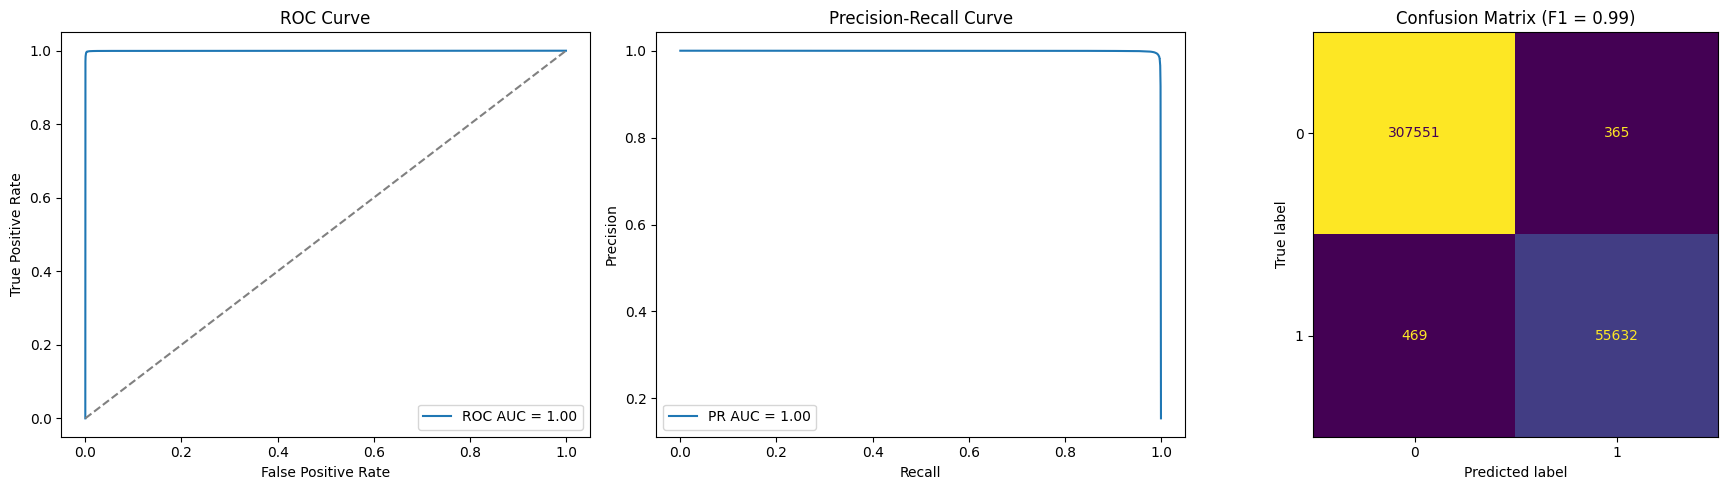

{'f1_macro': 0.9727038517982546,
 'roc_auc_macro': np.float64(0.9993937944049246),
 'pr_auc_macro': np.float64(0.9937701540217688)}

In [ ]:
random_forest_ab(df)

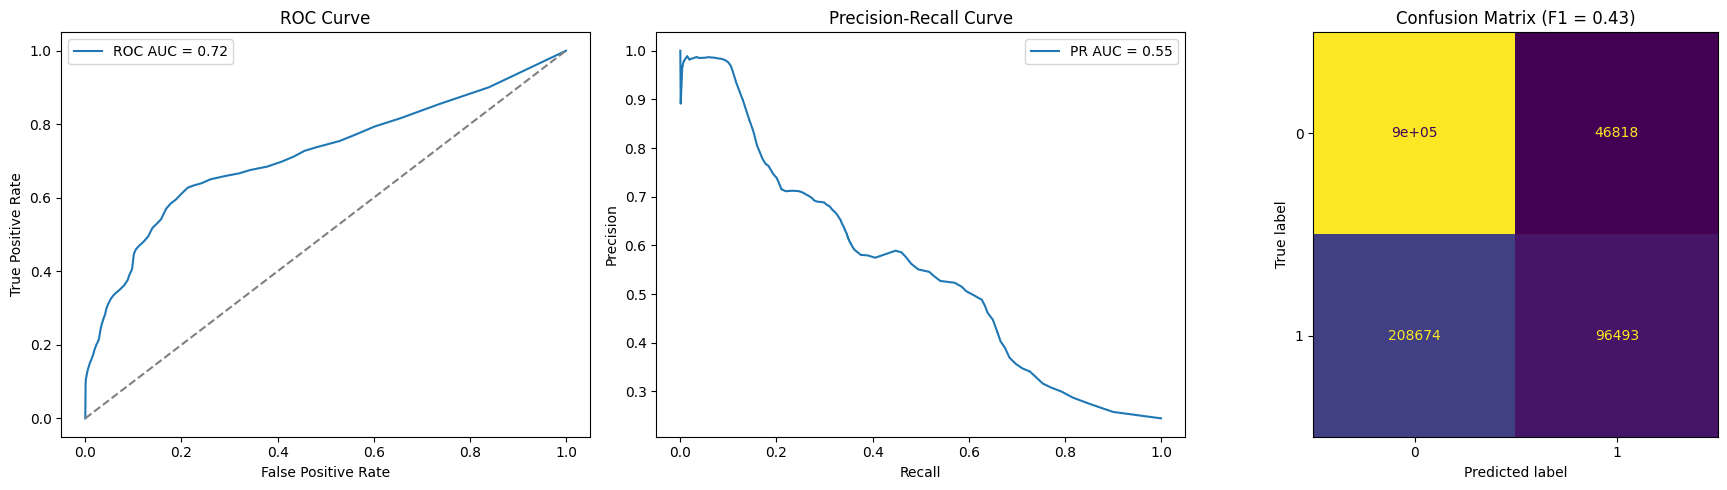

{'f1_macro': 0.4807352868884321,
 'roc_auc_macro': np.float64(0.7841629309042352),
 'pr_auc_macro': np.float64(0.5430354615138085)}

In [ ]:
random_forest_abc(df, df_eval)

# XGBoost

In [ ]:
def xgboost_ab(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X = df[feature_cols].copy()
    y = df["type"]

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    classes = le.classes_  # ['ddos', 'normal', 'sus']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=random_state,
        n_estimators=100
    )
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)

    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    roc_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_test_bin, y_prob, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    if "ddos" in classes:
        idx = list(classes).index("ddos")
        visualize_results((y_test == idx).astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

In [ ]:
def xgboost_abc(df: pd.DataFrame, df_eval: pd.DataFrame) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X_train = df[feature_cols].copy()
    y_train = df["type"]

    X_eval = df_eval[feature_cols].copy()
    y_eval = df_eval["type"]

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_eval_encoded = le.transform(y_eval)
    classes = le.classes_

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_eval_scaled = scaler.transform(X_eval)

    clf = XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=42,
        n_estimators=100
    )
    clf.fit(X_train_scaled, y_train_encoded)

    y_pred = clf.predict(X_eval_scaled)
    y_prob = clf.predict_proba(X_eval_scaled)

    y_eval_bin = label_binarize(y_eval_encoded, classes=[0, 1, 2])

    f1 = f1_score(y_eval_encoded, y_pred, average="macro")
    roc_auc = roc_auc_score(y_eval_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_eval_bin, y_prob, average="macro")

    if "ddos" in classes:
        idx = list(classes).index("ddos")
        visualize_results((y_eval_encoded == idx).astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:24:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


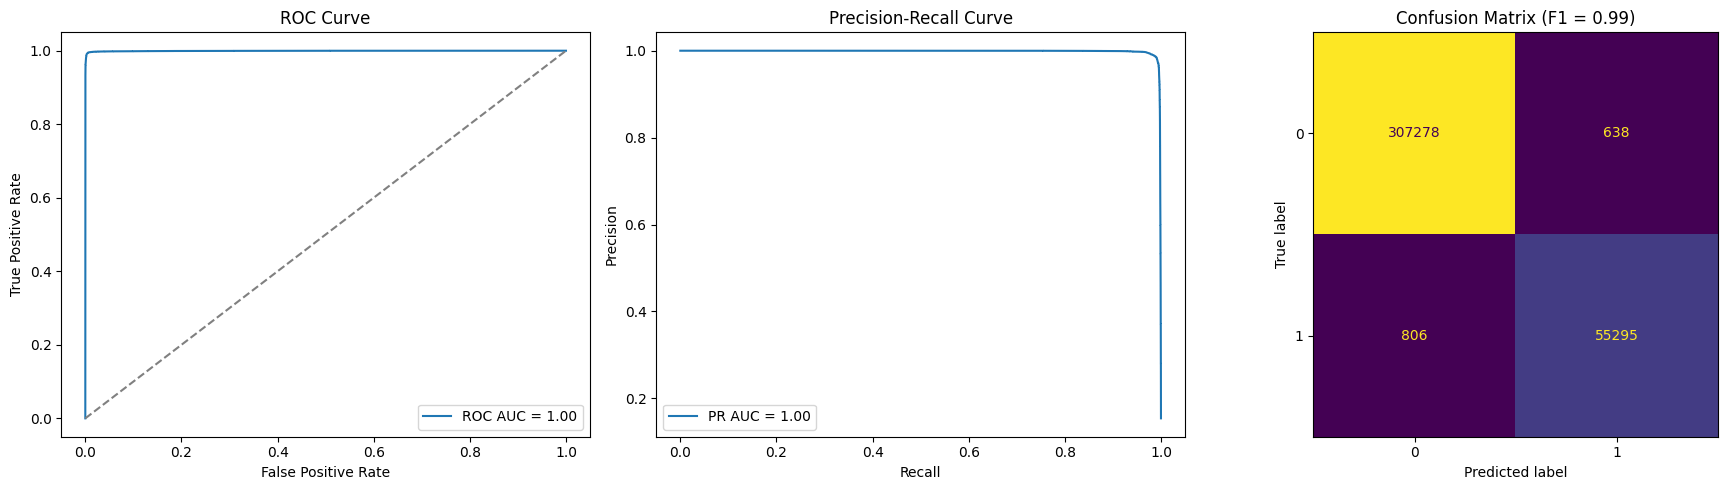

{'f1_macro': 0.9576199032830415,
 'roc_auc_macro': np.float64(0.9989077227459816),
 'pr_auc_macro': np.float64(0.9884181312739746)}

In [ ]:
xgboost_ab(df)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:26:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


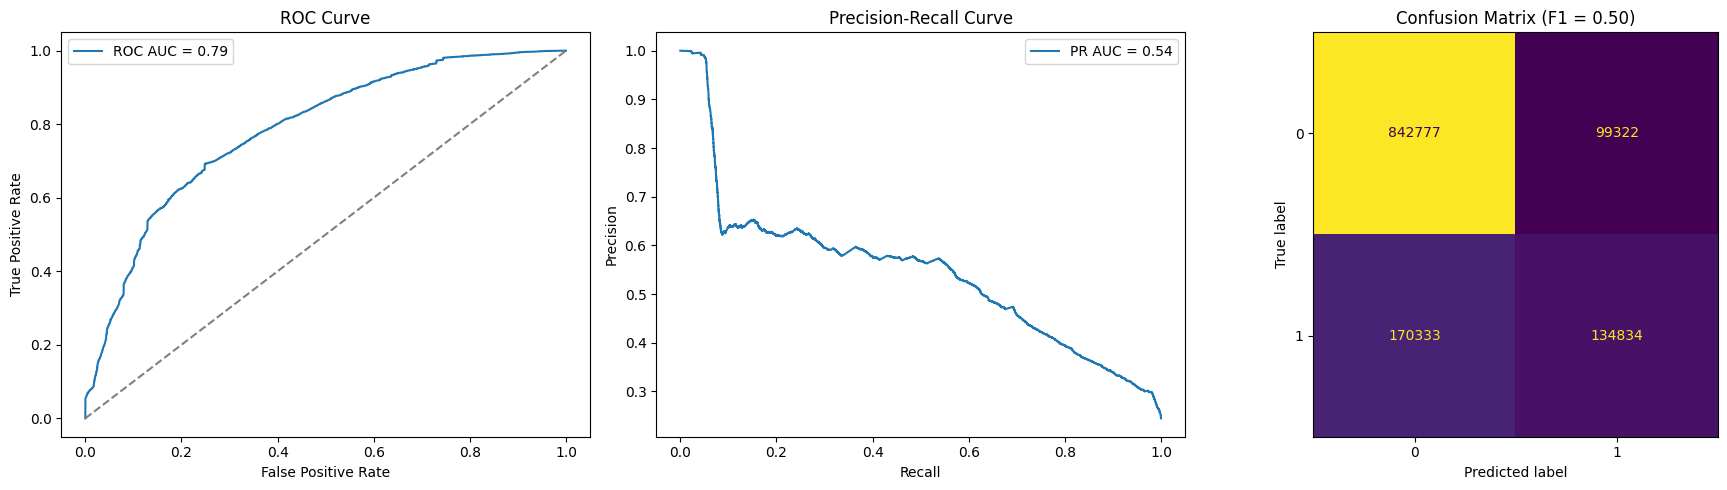

{'f1_macro': 0.5178897888841446,
 'roc_auc_macro': np.float64(0.8322530624915873),
 'pr_auc_macro': np.float64(0.5789538235825786)}

In [ ]:
xgboost_abc(df, df_eval)

# LightGBM

In [ ]:
def lightgbm_ab(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42) -> dict:
    import lightgbm as lgb
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, label_binarize
    from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

    feature_cols = [col for col in df.columns if col != "type"]
    X = df[feature_cols].copy()
    y = df["type"]

    classes = ["ddos", "normal", "sus"]
    y_bin = label_binarize(y, classes=classes)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = lgb.LGBMClassifier(random_state=random_state)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    y_prob = clf.predict_proba(X_test_scaled)

    y_test_bin = label_binarize(y_test, classes=classes)

    roc_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_test_bin, y_prob, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    if "ddos" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_test == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

In [ ]:
def lightgbm_abc(df: pd.DataFrame, df_eval: pd.DataFrame) -> dict:
    import lightgbm as lgb
    from sklearn.preprocessing import StandardScaler, label_binarize
    from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

    feature_cols = [col for col in df.columns if col != "type"]
    X_train = df[feature_cols].copy()
    y_train = df["type"]

    X_eval = df_eval[feature_cols].copy()
    y_eval = df_eval["type"]

    classes = ["ddos", "normal", "sus"]
    y_eval_bin = label_binarize(y_eval, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_eval_scaled = scaler.transform(X_eval)

    clf = lgb.LGBMClassifier(random_state=42)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_eval_scaled)
    y_prob = clf.predict_proba(X_eval_scaled)

    f1 = f1_score(y_eval, y_pred, average="macro")
    roc_auc = roc_auc_score(y_eval_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_eval_bin, y_prob, average="macro")

    if "ddos" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_eval == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 1456068, number of used features: 12
[LightGBM] [Info] Start training from score -1.870038
[LightGBM] [Info] Start training from score -0.211158
[LightGBM] [Info] Start training from score -3.317704


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


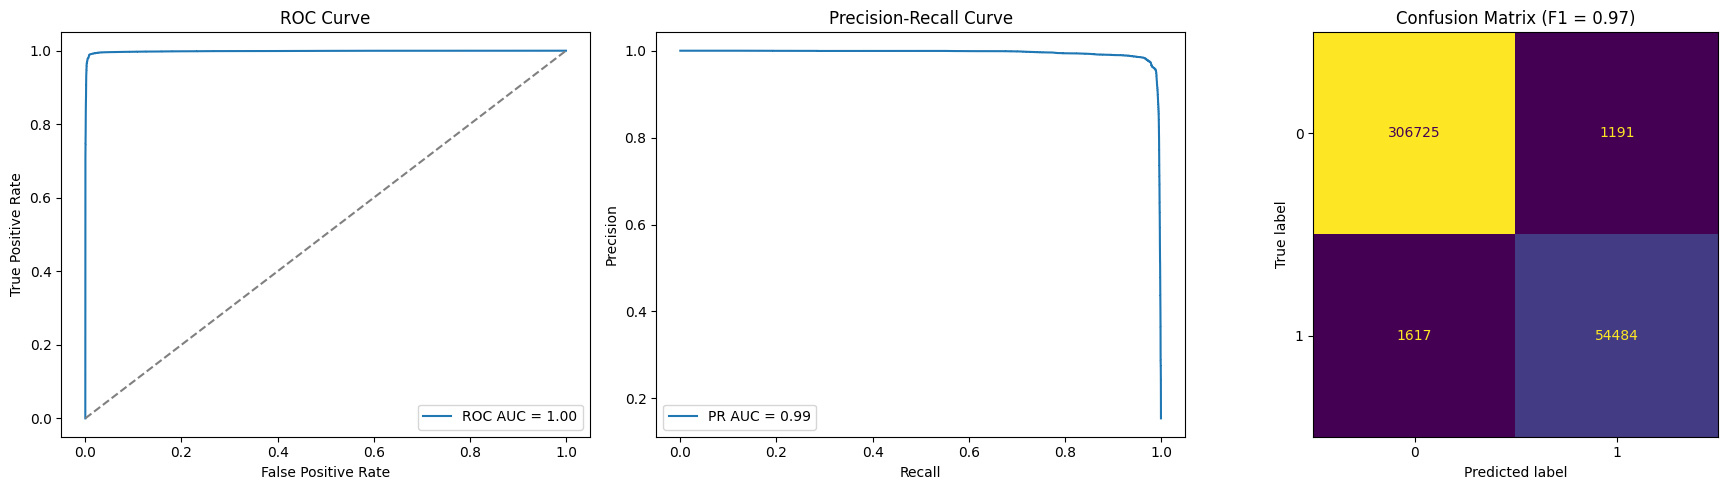

{'f1_macro': 0.9467150749126573,
 'roc_auc_macro': np.float64(0.9976668803787107),
 'pr_auc_macro': np.float64(0.9809186210469086)}

In [ ]:
lightgbm_ab(df)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 1820085, number of used features: 12
[LightGBM] [Info] Start training from score -1.870040
[LightGBM] [Info] Start training from score -0.211158
[LightGBM] [Info] Start training from score -3.317696


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


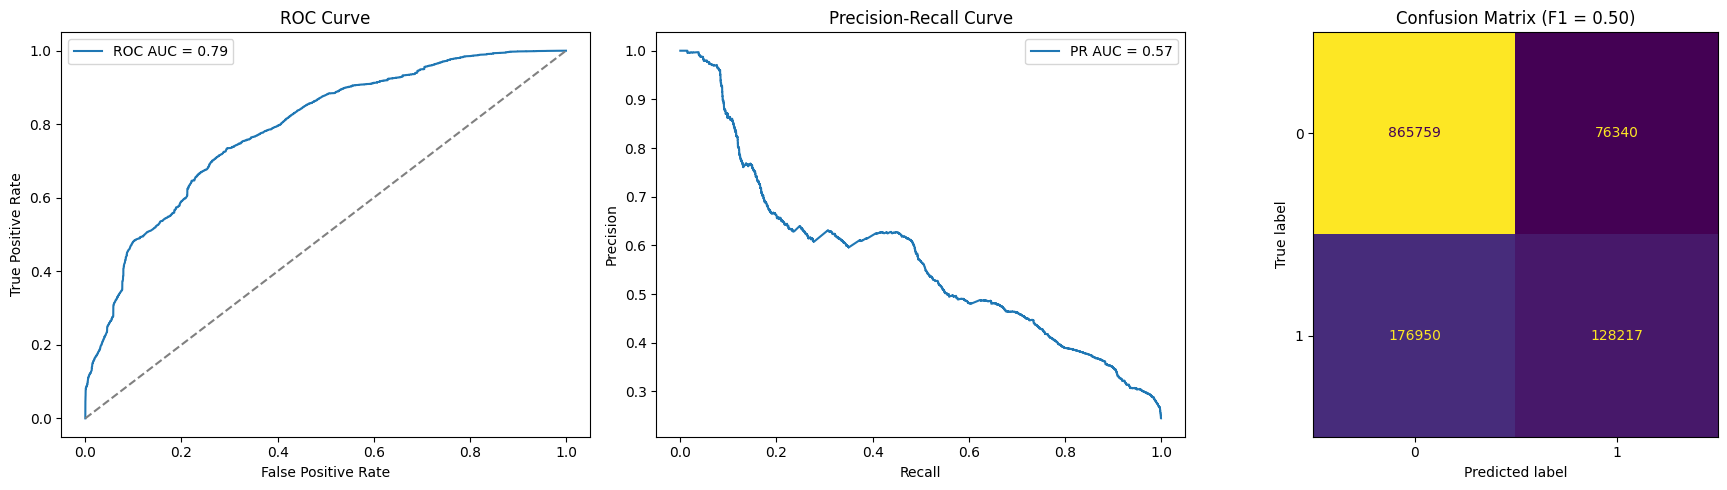

{'f1_macro': 0.5012242364159151,
 'roc_auc_macro': np.float64(0.8377190241800401),
 'pr_auc_macro': np.float64(0.5890288438391772)}

In [ ]:
lightgbm_abc(df, df_eval)

# CatBoost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier


In [ ]:
def catboost_ab(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X = df[feature_cols].copy()
    y = df["type"]

    classes = ["ddos", "normal", "sus"]
    y_bin = label_binarize(y, classes=classes)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function="MultiClass",
        verbose=0,
        random_state=random_state
    )
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled).ravel()
    y_prob = clf.predict_proba(X_test_scaled)

    y_test_bin = label_binarize(y_test, classes=classes)

    roc_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_test_bin, y_prob, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    if "ddos" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_test == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }


In [ ]:
def catboost_abc(df: pd.DataFrame, df_eval: pd.DataFrame) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X_train = df[feature_cols].copy()
    y_train = df["type"]

    X_eval = df_eval[feature_cols].copy()
    y_eval = df_eval["type"]

    classes = ["ddos", "normal", "sus"]
    y_eval_bin = label_binarize(y_eval, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_eval_scaled = scaler.transform(X_eval)

    clf = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function="MultiClass",
        verbose=0,
        random_state=42
    )
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_eval_scaled).ravel()
    y_prob = clf.predict_proba(X_eval_scaled)

    f1 = f1_score(y_eval, y_pred, average="macro")
    roc_auc = roc_auc_score(y_eval_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_eval_bin, y_prob, average="macro")

    if "ddos" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_eval == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

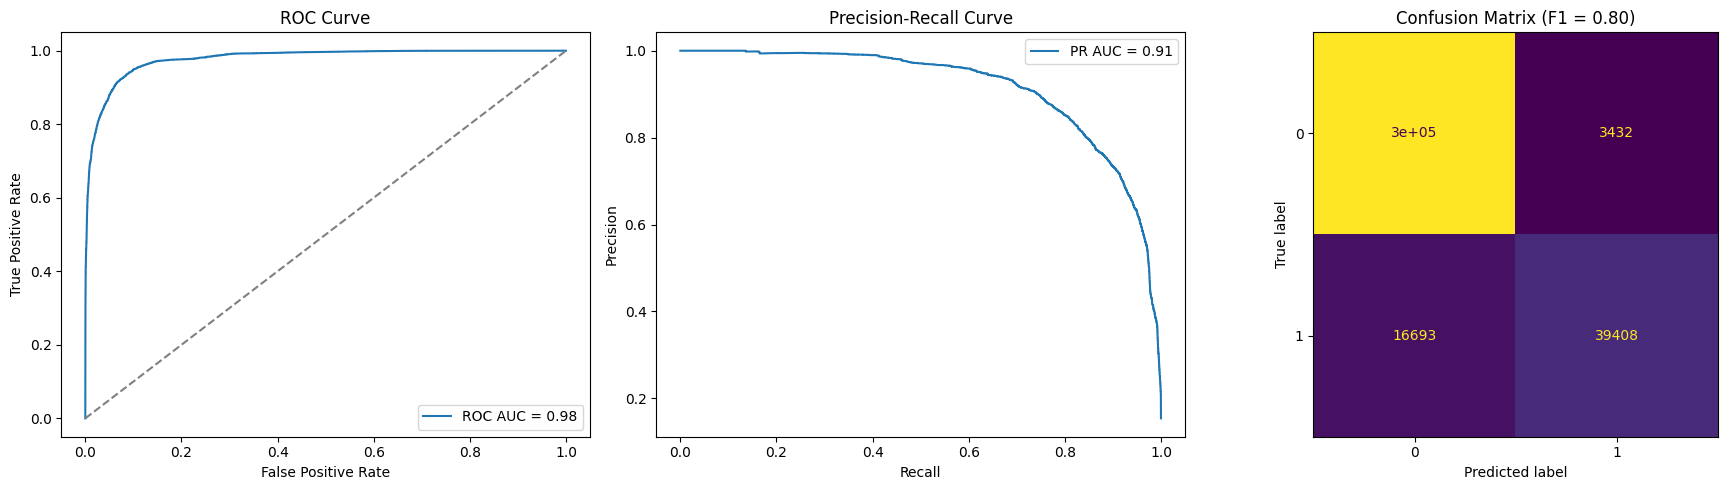

{'f1_macro': 0.8032361359858281,
 'roc_auc_macro': np.float64(0.9787220992684073),
 'pr_auc_macro': np.float64(0.9117928836079899)}

In [ ]:
catboost_ab(df)

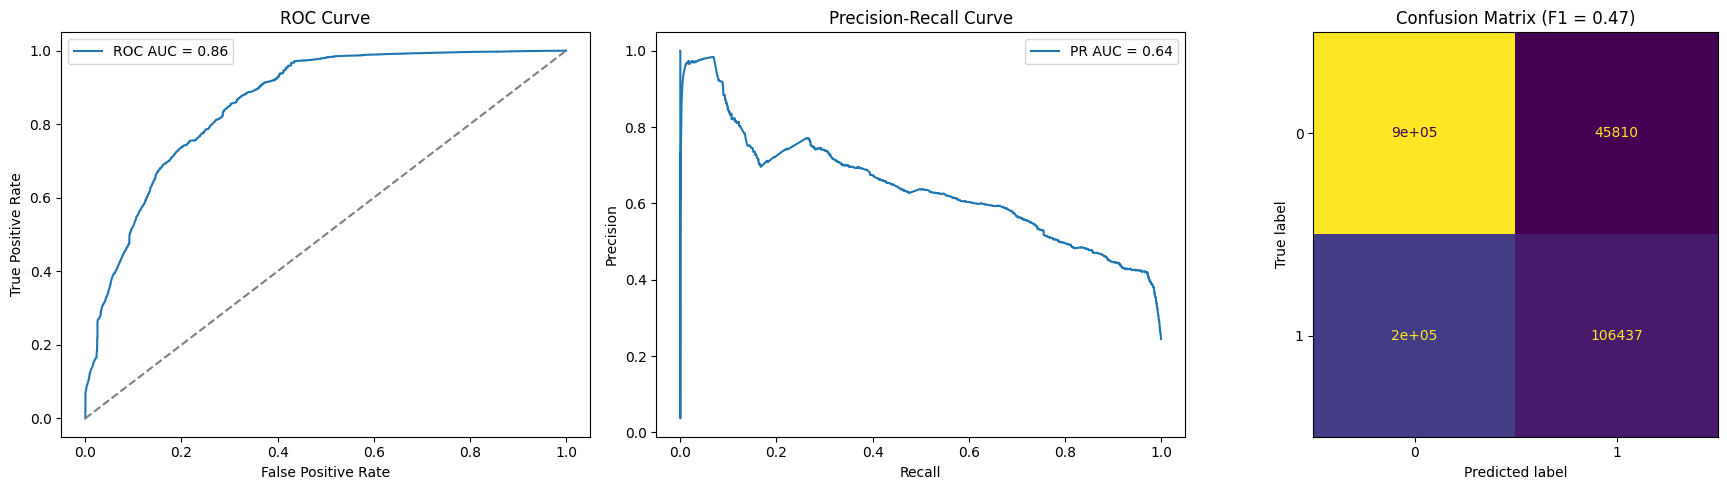

{'f1_macro': 0.5064504573666393,
 'roc_auc_macro': np.float64(0.8858471460665548),
 'pr_auc_macro': np.float64(0.6722869640155981)}

In [ ]:
catboost_abc(df, df_eval)

# Comparison

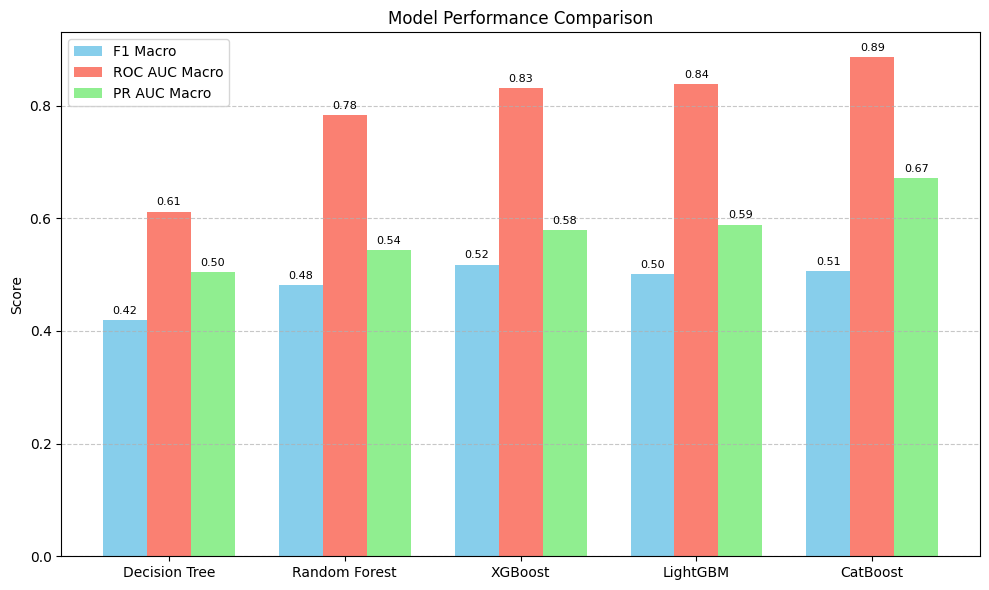

In [ ]:
models = ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
f1_scores = [0.419, 0.481, 0.518, 0.501, 0.506]
roc_auc_scores = [0.612, 0.784, 0.832, 0.838, 0.886]
pr_auc_scores = [0.504, 0.543, 0.579, 0.589, 0.672]

x = np.arange(len(models))
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, f1_scores, width, label='F1 Macro', color='skyblue')
bars2 = ax.bar(x, roc_auc_scores, width, label='ROC AUC Macro', color='salmon')
bars3 = ax.bar(x + width, pr_auc_scores, width, label='PR AUC Macro', color='lightgreen')

# Annotations
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Catboost optimalization

In [ ]:
def catboost_abc_class_weight(df: pd.DataFrame, df_eval: pd.DataFrame) -> dict:
    feature_cols = [col for col in df.columns if col != "type"]
    X_train = df[feature_cols].copy()
    y_train = df["type"]

    X_eval = df_eval[feature_cols].copy()
    y_eval = df_eval["type"]

    classes = ["ddos", "normal", "sus"]
    y_eval_bin = label_binarize(y_eval, classes=classes)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_eval_scaled = scaler.transform(X_eval)

    # Calculate class weights using the inverse of class frequencies
    class_weights = y_train.value_counts(normalize=True).to_dict()
    inverse_class_weights = {k: 1 / v for k, v in class_weights.items()}
    total_weight = sum(inverse_class_weights.values())
    normalized_weights = {k: total_weight * w for k, w in inverse_class_weights.items()}

    # Instantiate the classifier
    clf = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function="MultiClass",
        verbose=0,
        random_state=42
    )

    # Fit the model to the training data
    clf.fit(X_train_scaled, y_train)

    # Extract class weights based on the classifier's classes
    class_weight_list = [normalized_weights.get(c, 1) for c in clf.classes_]

    # Re-initialize the classifier with class weights
    clf = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function="MultiClass",
        verbose=0,
        random_state=42,
        class_weights=class_weight_list
    )
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_eval_scaled).ravel()
    y_prob = clf.predict_proba(X_eval_scaled)

    f1 = f1_score(y_eval, y_pred, average="macro")
    roc_auc = roc_auc_score(y_eval_bin, y_prob, average="macro", multi_class="ovr")
    pr_auc = average_precision_score(y_eval_bin, y_prob, average="macro")

    if "ddos" in clf.classes_:
        idx = list(clf.classes_).index("ddos")
        visualize_results((y_eval == "ddos").astype(int), y_prob[:, idx])

    return {
        "f1_macro": f1,
        "roc_auc_macro": roc_auc,
        "pr_auc_macro": pr_auc
    }

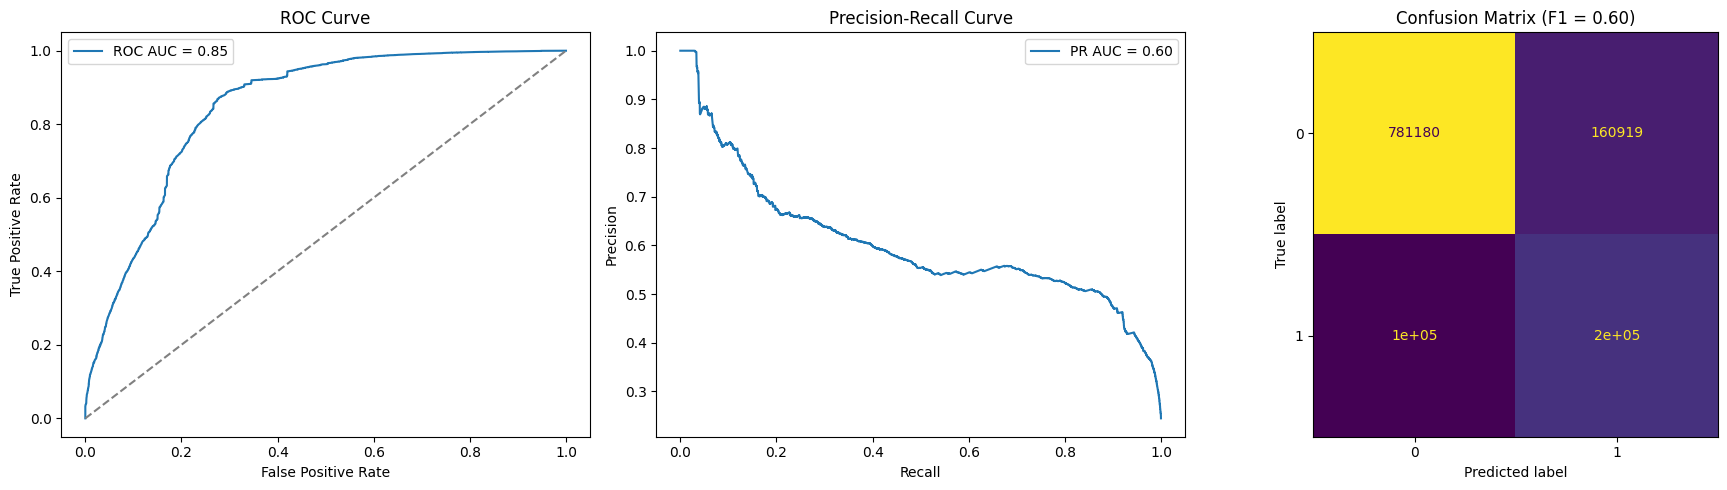

{'f1_macro': 0.6427788764727754,
 'roc_auc_macro': np.float64(0.8776670716428411),
 'pr_auc_macro': np.float64(0.6380909288597091)}

In [ ]:
catboost_abc_class_weight(df, df_eval)

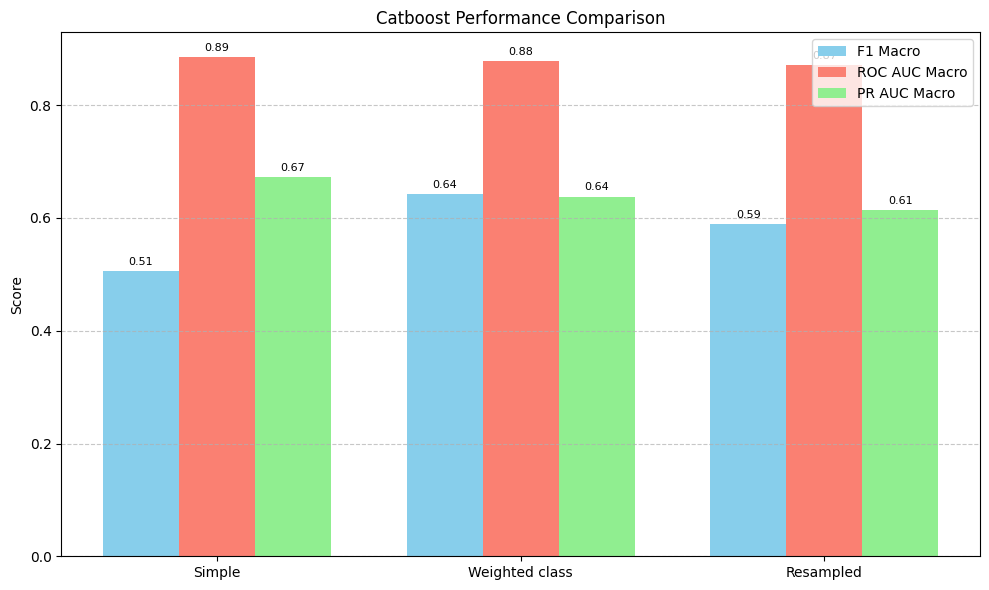

In [ ]:
models = ['Simple', 'Weighted class', 'Resampled']
f1_scores = [0.506, 0.642, 0.589]
roc_auc_scores = [0.885, 0.878, 0.871]
pr_auc_scores = [0.672, 0.638, 0.614]

x = np.arange(len(models))
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, f1_scores, width, label='F1 Macro', color='skyblue')
bars2 = ax.bar(x, roc_auc_scores, width, label='ROC AUC Macro', color='salmon')
bars3 = ax.bar(x + width, pr_auc_scores, width, label='PR AUC Macro', color='lightgreen')

# Annotations
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

ax.set_ylabel('Score')
ax.set_title('Catboost Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df_balanced = df.copy()

In [ ]:
print(df_balanced["type"].value_counts())

type
normal    1473625
ddos       280507
sus         65953
Name: count, dtype: int64


In [ ]:
df_balanced = df.copy()

rows_to_drop = df_balanced[df_balanced['type'] == 'normal'].sample(n=1000000, random_state=42).index
df_balanced = df_balanced.drop(rows_to_drop)

# Separate features and target
X = df_balanced.drop(columns=["type"])
y = df_balanced["type"]

sampler = SMOTE(sampling_strategy={"sus": 150000}, random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# Concatenate X_resampled and y_resampled along columns (axis=1)
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Reset index after concatenation
df_resampled = df_resampled.reset_index(drop=True)

# Check the resampled data
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904132 entries, 0 to 904131
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   victim_ip        904132 non-null  int64  
 1   port_number      904132 non-null  int64  
 2   packet_speed     904132 non-null  int64  
 3   data_speed       904132 non-null  int64  
 4   packet_len       904132 non-null  int64  
 5   source_ip        904132 non-null  int64  
 6   start_hour       904132 non-null  float64
 7   start_weekday    904132 non-null  float64
 8   start_dayofyear  904132 non-null  float64
 9   end_hour         904132 non-null  float64
 10  end_weekday      904132 non-null  float64
 11  end_dayofyear    904132 non-null  float64
 12  type             904132 non-null  object 
dtypes: float64(6), int64(6), object(1)
memory usage: 89.7+ MB


In [ ]:
print(df_resampled["type"].value_counts())

type
normal    473625
ddos      280507
sus       150000
Name: count, dtype: int64


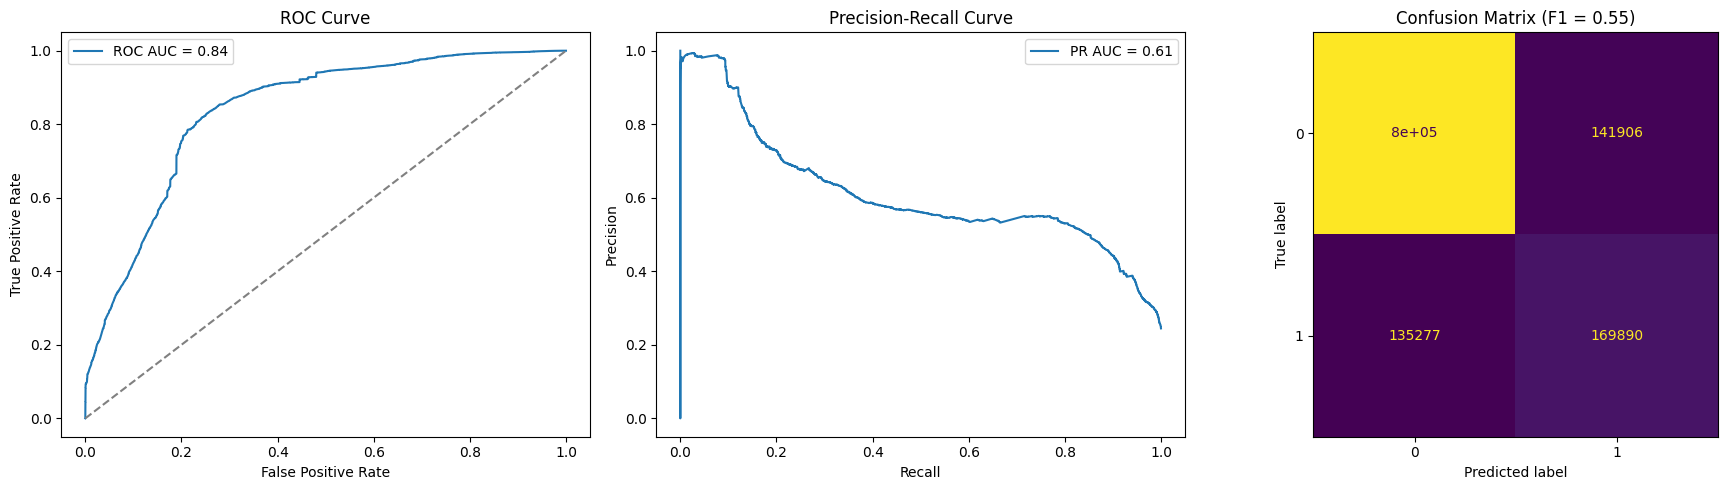

{'f1_macro': 0.5887195682996738,
 'roc_auc_macro': np.float64(0.8714375193905856),
 'pr_auc_macro': np.float64(0.614577842584671)}

In [ ]:
catboost_abc_class_weight(df_resampled, df_eval)